# Data Visualization Notebook

**Make sure that you have run data_collection.ipynb before running this one.**

## Objectives

- Address business requiremenent 1:
    - The client is interested in conducting a study to visually differentiate a cherry leaf that is healthy from one that contains powdery mildew.

## Inputs

This notebook will use the following inputs:
- inputs/cherry-leaves/cherry-leaves/test
- inputs/cherry-leaves/cherry-leaves/train
- inputs/cherry-leaves/cherry-leaves/validation

## Outputs

This notebook will generate the following outputs:
- A pickle file storing image shape embeddings (image data stored as a numercal representation) 
- Plots that show the mean (average) image and variability of images for each label
- A plot to show the difference beween healthy leaves and mildewed leaves
- Code to address business requirement 1 and build an image montage

## Import Packages

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random
sns.set_style("white")
from pathlib import Path
from matplotlib.image import imread
from PIL import Image
from tensorflow.keras.preprocessing import image

## Change working directory

By default, the working directory is "jupyter_notebooks", where the notebook is running. However, we need to change the working directory to its parent folder so that file references align with the broader project structure.

To do this, we first check the current working directory — note that the output below only displays the last two folders in the file path, rather than the full system path. This is done intentionally to prevent exposing the full local file path stored on my machine.

**Any time you revisit this notebook after logging out, or open a different notebook for the first time, you must repeat these steps to ensure the working directory is always correctly set.**

In [1]:
import os
from pathlib import Path # ensure file path consistency

# Get the current working directory
current_dir = Path.cwd()

# Extract the last two directory names
filtered_path = Path(*current_dir.parts[-2:])
print(f"📂 {filtered_path}")  # Example output: 📂 mildew_detector/jupyter_notebooks

📂 mildew_detector\jupyter_notebooks


Now we change the working directory from "jupyter_notebooks" to the parent directory.

In [2]:
# Change the working directory to its parent folder
os.chdir(os.path.dirname(os.getcwd()))

# Confirmation message with
print("✅ You set a new current directory")

✅ You set a new current directory


Confirm the new current directory.

In [3]:
# Get the current working directory
current_dir = Path.cwd()

# Extract the last two directory names
filtered_path = Path(*current_dir.parts[-2:])
print(f"📂 {filtered_path}")  # Example output: 📂 mildew_detector/jupyter_notebooks

📂 Projects\mildew_detector


### Set the input directories

Now we need to define the paths where this notebook will find the data we'll be using.

In [4]:
# Define base image data path
image_data = Path("inputs") / "cherry-leaves" / "cherry-leaves"

# Define paths for train, validation, and test sets
train_path = image_data / "train"
val_path = image_data / "validation"
test_path = image_data / "test"

# Print paths
print(f"📂 Train Path: {train_path}")
print(f"📂 Validation Path: {val_path}")
print(f"📂 Test Path: {test_path}")

📂 Train Path: inputs\cherry-leaves\cherry-leaves\train
📂 Validation Path: inputs\cherry-leaves\cherry-leaves\validation
📂 Test Path: inputs\cherry-leaves\cherry-leaves\test


### Confrim that the file paths are valid

Now we'll run a function just to check that the file paths defined above are valid.

The function will select one image from each train, test and validation folder and display it below along with the file path beginning with the "inputs" folder.

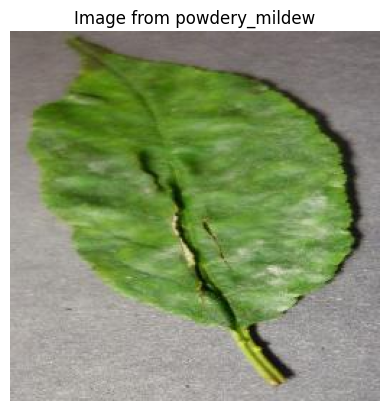

✅ Random train image: inputs\cherry-leaves\cherry-leaves\train\powdery_mildew\da2dd4af-37c1-4951-8fd3-e869cd3007b9___FREC_Pwd.M 4976.JPG


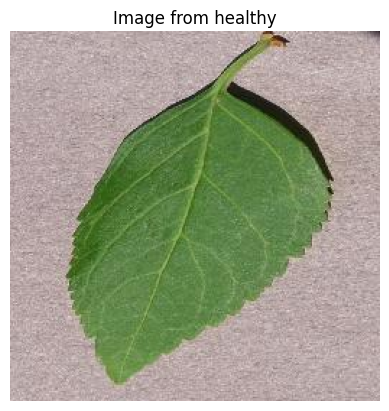

✅ Random validation image: inputs\cherry-leaves\cherry-leaves\validation\healthy\85cfbde6-c86e-487a-8a6f-c8d2db72d9af___JR_HL 9888_180deg.JPG


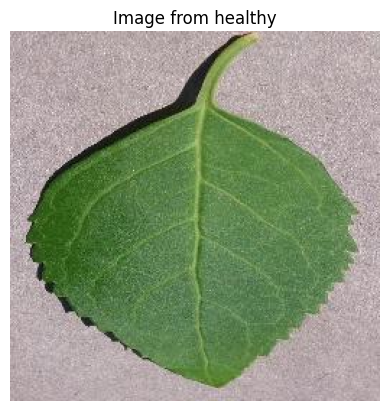

✅ Random test image: inputs\cherry-leaves\cherry-leaves\test\healthy\68734aec-344c-4cdf-88ea-404d8cd90889___JR_HL 9625_180deg.JPG


In [8]:
from pathlib import Path

# Function to find and display a random image from subfolders
def show_random_image(parent_folder):
    """
    Selects and displays a random image from a subfolder inside the given parent directory.

    Args:
        parent_folder (str or Path): The path to the main dataset folder (e.g., train, validation, test).

    Returns:
        str or None: The full path to the randomly selected image, or None if no images are found.
    """
    
    parent_folder = Path(parent_folder)  # Ensure it's a Path object

    # Ensure the parent folder exists
    if not parent_folder.exists():
        print(f"❌ Path does not exist: {parent_folder}")
        return None

    # Scan subdirectories ("healthy", "powdery_mildew")
    subfolders = [f for f in parent_folder.iterdir() if f.is_dir()]
    
    if not subfolders:
        print(f"⚠️ No subfolders found in: {parent_folder}")
        return None

    # Pick a random subfolder
    chosen_folder = random.choice(subfolders)

    # Find image files inside that subfolder
    image_files = [f for f in chosen_folder.iterdir() if f.suffix.lower() in {'.png', '.jpg', '.jpeg', '.bmp', '.webp'}]

    if not image_files:
        print(f"⚠️ No images found in: {chosen_folder}")
        return None

    # Select a random image and display it
    chosen_image = random.choice(image_files)

    # Load image using PIL
    image = Image.open(chosen_image)

    plt.imshow(image)
    plt.title(f"Image from {chosen_folder.name}")
    plt.axis("off")  # Hide axes for a cleaner look
    plt.show()

    return str(chosen_image)  # Return path for confirmation

# Fetch and display random images from each dataset section
train_image = show_random_image(train_path)
print(f"✅ Random train image: {train_image}")
val_image = show_random_image(val_path)
print(f"✅ Random validation image: {val_image}")
test_image = show_random_image(test_path)
print(f"✅ Random test image: {test_image}")

## Create an "outputs" Directory

We now need a place to store any new files that we'll be creating.

The cell below will check to see if "outputs" already exists. If not, it will create one and set a file path to it.

In [ ]:
from pathlib import Path

# Define the root directory
root_dir = Path.cwd()  # Get current working directory
version = "v1"

# Construct the relative path for outputs
file_path = Path("outputs") / version

# Check if the directory for this version already exists
if file_path.exists():
    print(f'⚠️ Old version "{version}" already exists and the file path to it has just been set.') 
    print(f'Create a new version if required. If not, you are good to go!👍')
else:
    try:
        # Create the directory if it doesn't exist
        file_path.mkdir(parents=True, exist_ok=True)
        print(f'✅ Created new directory: 📂 {file_path}')
    except OSError as e:
        print(f'❌ Error creating directory: {e}')

✅ Created new directory: 📂 outputs\v1


## Set the Label Names

Our upcoming binary classification task will require labeled data in order to train. Here we will set the labels to be used in our project:

- 'healthy'
- 'powdery_mildew'

In [14]:
# Set the labels
labels = os.listdir(train_path)
print('🏷️ The labels for the images are', labels)

🏷️ The labels for the images are ['healthy', 'powdery_mildew']
